# Tutorial: fitting a Synchrotron Self Compton spectrum using sherpa

In this tutorial we will show how to write a small `sherpa` wrapper of the `agnopy` functions that will allow us to fit the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[sherpa](https://sherpa.readthedocs.io/en/latest/index.html) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
# import agnpy classes
import agnpy
from agnpy.spectra import LogParabola
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed
load_mpl_rc()

In [3]:
# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar, NelderMead

### function to rebin the data 
In the dataset we will use there are a lot of overlapping X-ray data, we will define here a function to rebin the spectral flux points. We will just perform the weighted arithmetic mean of all the flux points falling in the chosen bins.

In [4]:
def rebin_sed(nu, nuFnu, nuFnu_err, nu_bins):
    """rebin the SED data
    
    Parameters
    ----------
    nu : `~astropy.units.Quantity`
        array of flux points frequencies
    nuFnu : `~astropy.units.Quantity`
        array of flux points values
    nuFnu_err : `~astropy.units.Quantity`
        array of flux points errors
    nu_bins: int
        re-bin the data between `nu[0]` and `nu[-1]` in `nu_bin` bins
    
    Returns
    -------
    three arrays containing the new bin centers, flux values and errors
    """
    nu_bins_ctr = []
    nuFnu_binned = []
    nuFnu_err_binned = []
    for i in range(len(nu_bins) - 1):
        nu_min, nu_max = nu_bins[i], nu_bins[i + 1]
        # which points in this bin?
        condition = (nu_min <= nu) * (nu <= nu_max)
        # go to the next bin if there are no spectral points in this
        if not np.any(condition):
            continue
        else:
            y = nuFnu[condition]
            y_err = nuFnu_err[condition]
            y_new = np.sum(y * np.power(y_err, -2)) / np.sum(np.power(y_err, -2))
            y_err_new = 1 / np.sqrt(np.sum(np.power(y_err, -2)))
            nu_bins_ctr.append(np.sqrt(nu_min * nu_max))
            nuFnu_binned.append(y_new)
            nuFnu_err_binned.append(y_err_new)
    return (
        np.asarray(nu_bins_ctr),
        np.asarray(nuFnu_binned),
        np.asarray(nuFnu_err_binned),
    )

### sherpa wrapper of agnpy synchrotron and SSC
Now let us [follow the sherpa documentation](https://sherpa.readthedocs.io/en/latest/model_classes/usermodel.html) and define a model wrapping agnpy's functions to compute the Synchrotron and Synchrotron Self Compton SEDs. We will assume a log-parabolic electorn distribution.

**NOTE:** for the parameters that vary over several orders of magnitude (i.e. normalisation and Lorentz factors of the electron distirbutions) it is better to provide to the model that will be used by the fitting routine a "scaled" version of them (e.g. their log10), such that larger steps might be covered with small parameters variation.

In [5]:
class LogParabolaSSC(model.RegriddableModel1D):
    """wrapper of agnpy's synchrotron and SSC classes. A log-parabola is assumed for the electron spectrum.
    The log10 of the normalisation and Lorentz factors (and magnetic field) are feeded to this model"""
    
    def __init__(self, name="ssc"):
        self.log10_k_e = model.Parameter(name, "log10_k_e", -11, min=-20, max=-3)
        self.p = model.Parameter(name, "p", 2.2, min=1.0, max=5.0)
        self.q = model.Parameter(name, "q", 0.2, min=0.0, max=3.0)
        self.log10_gamma_0 = model.Parameter(name, "log10_gamma_0", 3, min=2, max=6) 
        self.log10_gamma_min = model.Parameter(name, "log10_gamma_min", 1, min=0, max=3)
        self.log10_gamma_max = model.Parameter(name, "log10_gamma_max", 5, min=4, max=9)
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33)
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=50)
        self.log10_B = model.Parameter(name, "log10_B", -2, min=-4, max=2)
        self.R_b = model.Parameter(name, "R_b", 1e16, min=1e14, max=1e18)
        
        model.RegriddableModel1D.__init__(self, name,
                                          (self.log10_k_e, self.p, self.q, 
                                           self.log10_gamma_0, self.log10_gamma_min, self.log10_gamma_max,
                                           self.z, self.d_L, self.delta_D, self.log10_B, self.R_b))

    def calc(self, pars, x):
        """evaluate the model, scale back the logarithmic parameters"""
        (log10_k_e, p, q, log10_gamma_0, log10_gamma_min, log10_gamma_max, z, d_L, delta_D, log10_B, R_b) = pars
        # add units, scale quantities
        k_e = 10**log10_k_e * u.Unit("cm-3")
        gamma_0 = 10**log10_gamma_0
        gamma_min = 10**log10_gamma_min
        gamma_max = 10**log10_gamma_max
        B = 10**(log10_B) * u.G
        d_L *= u.cm
        R_b *= u.cm
        x *= u.Hz
        
        sed_synch = Synchrotron.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, LogParabola, k_e, p, q, gamma_0, gamma_min, gamma_max
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x, z, d_L, delta_D, B, R_b, LogParabola, k_e, p, q, gamma_0, gamma_min, gamma_max
        )
        return sed_synch + sed_ssc

### fitting with sherpa
Let us start here the procedure to fit with sherpa, first we re-bin the data

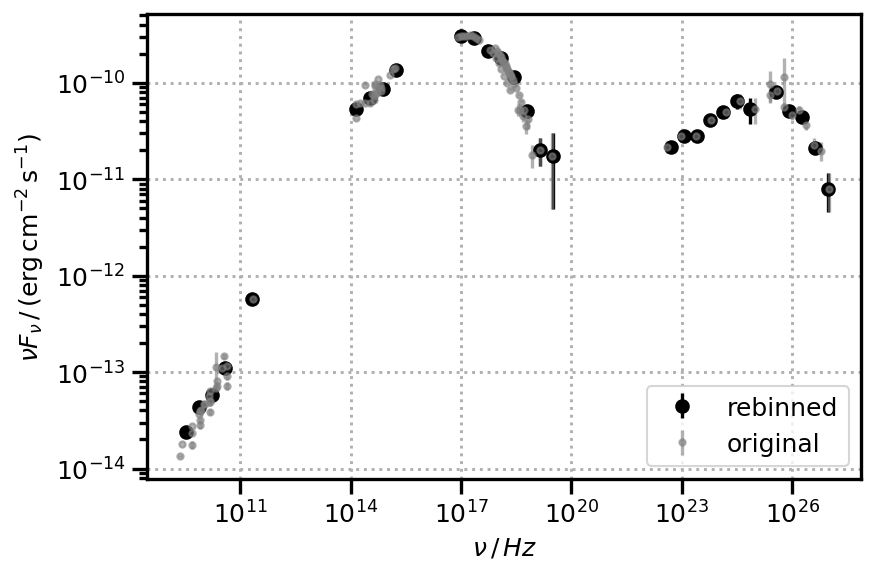

In [6]:
# read the 1D data
sed_path = Path(agnpy.__file__).parent / "data/mwl_seds/Mrk421_2011.ecsv"
sed_table = Table.read(sed_path)
x = sed_table["nu"]
y = sed_table["nuFnu"] 
y_err = sed_table["nuFnu_err"]
# rebin them
nu_bins = np.logspace(9, 30, 60)
x_new, y_new, y_err_new = rebin_sed(x, y, y_err, nu_bins)
# plot the rebinned and old data
plt.errorbar(x_new, y_new, yerr=y_err_new, ls="", marker="o", color="k", label="rebinned")
plt.errorbar(x, y, yerr=y_err, ls="", marker=".", color="gray", alpha=0.6, label="original")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend()
plt.show()

Then we pass the data in the `Data1D` object provided by sherpa

In [7]:
# load them in a sherpa data object
sed = data.Data1D("sed", x_new, y_new, staterror=y_err_new)

Create an instance of the model wrapping the synchrotron and SSC functionalities we defined above.
Let us initialise all the blob parameters with the parameters provided in the paper [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract). Let us leave free to vary only the parameters describing the electron distribution.

In [8]:
# instance of the model wrapping angpy functionalities
model = LogParabolaSSC()
# parameters from Table 4 and Figure 11 of Abdo 2011
R_b = 5.2 * 1e16 * u.cm
z = 0.0308
d_L = Distance(z=z).to("cm")
B = 3.8 * 1e-2 * u.G
# load and freeze all the blob parameters
# - blob parameters
model.delta_D = 21
model.delta_D.freeze()
model.z = z
model.z.freeze()
model.d_L = d_L.cgs.value
model.d_L.freeze()
model.R_b = R_b.cgs.value
model.R_b.freeze()
model.log10_B = np.log10(B.to_value("G")) 
model.log10_B.freeze()
# load and let free all the electron distribution parameters, just fix the minimum and maximum Lorentz factors
# - electron distribution
model.log10_k_e = -7
model.log10_gamma_0 = np.log10(1e4)
model.p = 2.1
model.q = 0.6
model.log10_gamma_min = np.log10(1e2)
model.log10_gamma_min.freeze()
model.log10_gamma_max = np.log10(1e7)
model.log10_gamma_max.freeze()
print(model)

ssc
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   ssc.log10_k_e thawed           -7          -20           -3           
   ssc.p        thawed          2.1            1            5           
   ssc.q        thawed          0.6            0            3           
   ssc.log10_gamma_0 thawed            4            2            6           
   ssc.log10_gamma_min frozen            2            0            3           
   ssc.log10_gamma_max frozen            7            4            9           
   ssc.z        frozen       0.0308         0.01            1           
   ssc.d_L      frozen  4.30448e+26        1e+25        1e+33           
   ssc.delta_D  frozen           21            0           50           
   ssc.log10_B  frozen     -1.42022           -4            2           
   ssc.R_b      frozen      5.2e+16        1e+14        1e+18           


Now we define the Fit procedure choosing the statistics (chi2) and the minimisation method. We will fit only the data between $10^{11}\,{\rm Hz}$ and $10^{29}\,{\rm Hz}$, avoiding the lowest-energy radio data usually attributed to the extended jet emission.

In [9]:
# fit using the Levenberg-Marquardt optimiser
fitter = Fit(sed, model, stat=Chi2(), method=LevMar())
min_x = 1e11
max_x = 1e29
sed.notice(min_x, max_x)

In [10]:
%%time
# perform the fit and time it!
results = fitter.fit()
print("-- fit succesful?", results.succeeded)
print(results.format())

-- fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 3.94681e+06
Final fit statistic   = 39329.3 at function evaluation 84
Data points           = 25
Degrees of freedom    = 21
Probability [Q-value] = 0
Reduced statistic     = 1872.82
Change in statistic   = 3.90748e+06
   ssc.log10_k_e   -5.84405     +/- 1.52654     
   ssc.p          1.46646      +/- 1.26274     
   ssc.q          0.603364     +/- 0.00328915  
   ssc.log10_gamma_0   3.93155      +/- 1.0416      
CPU times: user 6.92 s, sys: 1.88 s, total: 8.79 s
Wall time: 8.79 s


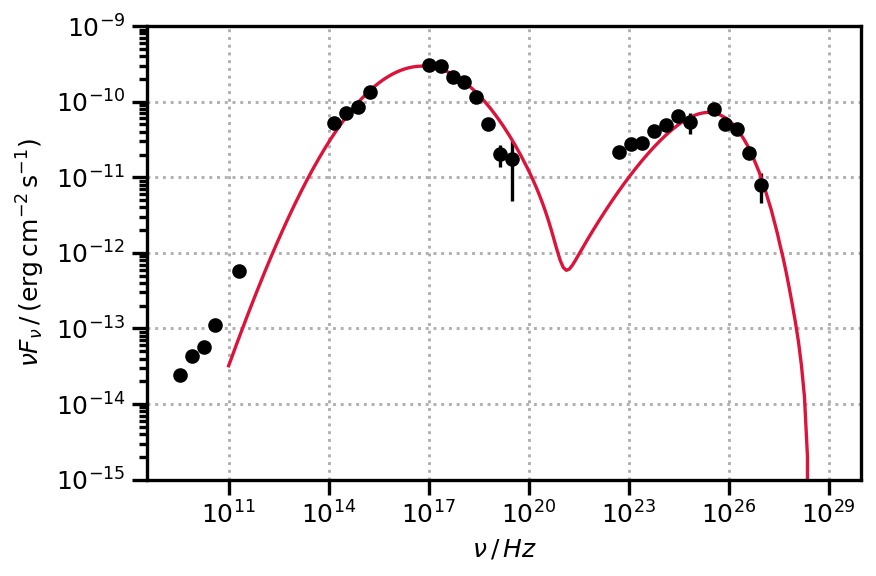

In [11]:
# plot the results!
x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
plt.errorbar(sed.x, sed.y, yerr=sed.staterror, marker="o", ls="", color="k")
plot_sed(x, model(x), ls="-", color="crimson")
plt.ylim([1e-15, 1e-9])
plt.show()